# BG69: SVM参数的两种求解方法

支持向量机(Support Vector Machine, SVM)曾经是传统机器学习模型中的神话，各种文章都在努力挖掘它的潜力。在数学上具有高度的可解释性是SVM的一大优势，高效的序列最小优化(Sequential Minimal Optimization, SMO)算法为其求解参数提供了极大便利。深度学习兴起之后，使用梯度下降来进行误差反传以求解参数的方法对于SVM是否适用呢？本文就提供SMO和随机梯度下降(Stochastic Gradient Descent, SGD)两种参数求解方法供大家参考。

## 1. SVM的模型描述

可以回顾一下感知机解决一个分类问题的思路：对误分类点建立损失函数，通过优化损失函数减少误分类点，直到没有误分类点。这样就存在一个问题，即满足这种要求的分类超平面是有无穷多个的，却无法从这无穷多个解中确定最优的参数解。那么有没有办法定义一种准则来进一步评价超平面的优化程度呢？SVM提供了另一种思路：定义样本点到分类超平面的距离为间隔，使得所有样本点到分类超平面的间隔离最大化所得到的参数就是最优解，而且对于一个线性可分的二分类问题，这个最优解还是唯一的。

样本点 $(X_i, y_i)$ 与分类超平面 $WX+b=0$ 的几何间隔$\gamma_i$ 可以由下式表示
$$
\gamma_i = y_i\frac{WX_i+b}{\|W\|}
$$

要想所有样本点到超平面的几何间隔最大，可以使用以下优化方程进行描述
$$
\max\limits_{W, b} \gamma
$$
应当满足的约束条件如下：
$$
s.t. y_i\frac{WX_i+b}{||W||} \geq \gamma, i=1,2,...,n
$$
由于几何间隔$\gamma$与函数间隔$\hat\gamma$具有一个比例关系 $\gamma = \frac{\hat\gamma}{\|W\|}$，则以上优化方程可以描述为
$$
\max\limits_{W, b} \frac{\hat\gamma}{\|W\|}
$$
函数间隔应当满足的约束条件如下：
$$
s.t. y_i(WX_i+b) \geq \hat\gamma, i=1,2,...,n
$$
由于在这个优化问题中$\hat\gamma$是一个常数，我们可以假定其大小为单位 $1$。同时，优化 $\max\limits_{W,b} \frac{1}{\|W\|}$ 与优化 $\max\limits_{W, b} \frac{1}{2}\|W\|^2$ 是等价的，因此，以上优化方程又可以转换为如下形式：
$$
\max\limits_{W, b} \frac{1}{2}\|W\|^2
$$
$$
s.t. y_i(WX_i + b) - 1 \geq 0, i=1,2,...,n
$$
到此，就可以使用拉格朗日乘数法构建一个新的便于求解的优化问题。由于新的优化问题求解起来仍然困难，所以还需要利用对偶原理构造当前优化问题的对偶问题，然后通过求解对偶问题来获得当前优化问题的解。

从以上优化问题的描述，我们可以看出，只有在超平面 $y(WX + b) - 1 = 0$ 上的样本点才是对优化有效的点，这些点也被称作“支持向量(Support Vectors)”。对偶问题的优化实质上就是找出这些“支持向量“，从而逆向求解出参数 $W$。除此之外，还有另一种求解思路，即直接从损失函数优化的角度解决。下面就对这两种求解方式的软件求解和结果进行说明。

In [1]:
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

# read data from file
data_path = '../data/bg68/data.txt'
data = np.genfromtxt(data_path, delimiter='\t')
X, Y = data[:, :2], data[:, 2].astype(dtype=np.int)
Y[Y==0] = -1
#shuffle
shuffle_idx = np.arange(Y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, Y = X[shuffle_idx], Y[shuffle_idx]
# split samples into trainset and testset
num_sample = X.shape[0]
num_train = int(num_sample*0.7)
X_train, X_test = X[:num_train, :], X[num_train:, :]
Y_train, Y_test = Y[:num_train], Y[num_train:]
# normalization
miu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
print('miu={}, sigma={}'.format(miu,sigma))
X_train, X_test = (X_train - miu)/sigma, (X_test - miu)/sigma
X_train = X_train.astype(dtype=np.float32)
X_test = X_test.astype(dtype=np.float32)
print(X_train.shape, X_test.shape)
x_train_max = np.max(np.abs(X_train))
x_test_max = np.max(np.abs(X_test))
max_x = int(max(x_train_max, x_test_max)) + 1
print(X_train.shape, X_test.shape)

miu=[0.07       0.20385714], sigma=[2.24407919 2.27913724]
(70, 2) (30, 2)
(70, 2) (30, 2)


In [2]:
def plot_samples(X, Y, max_x, title):
    plt.scatter(X[Y==-1, 0], X[Y==-1, 1], c='green', label='class -1', marker='o')
    plt.scatter(X[Y==1, 0], X[Y==1, 1], c='blue', label='class 1', marker='s')
    plt.title(title, color='red')
    plt.xlabel('(x)-feature 0')
    plt.ylabel('(y)-feature 1')
    plt.xlim((-max_x, max_x))
    plt.ylim((-max_x, max_x))
    
    
def plot_fig(X_train, Y_train, X_test, Y_test, W, b, title='SVM', svs=None):
    # w0*x+w1*y+b=0
    x0 = -max_x
    y0 = (-b[0]-W[0,0]*x0)/W[1,0]
    x1 = max_x
    y1 = (-b[0]-W[0,0]*x1)/W[1,0]
    # plot
    plt.subplot(1,2,1)
    plt.plot([x0, x1], [y0, y1], '-')
    plot_samples(X_train, Y_train, max_x, '{} on trainset'.format(title))
    if svs is not None:
        plt.scatter(svs[:, 0], svs[:, 1], c='red', label='support vectors', marker='^')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot([x0, x1], [y0, y1], '-')
    plot_samples(X_test, Y_test, max_x, '{} on testset'.format(title))
    plt.legend()

## 2. 使用SMO算法优化

一种传统的求解算法是序列最小优化(Sequential Minimal Optimization, SMO)，该算法由libsvm开源代码库实现。scipy模块提供的支持向量分类(Support Vector Classification, SVC)正是通过调用libsvm的求解器来实现的。在机器学习中，我们认为损失函数中的 $\|W\|$ 这一项是一种正则(Regularization)，因为该项会对复杂的参数配置进行惩罚，从而获得相对简单的参数解。在scipy的SVC中，输入参数参数 C 即是以$\frac{1}{C}$的方式作用于正则项 $\|W\|$，通过调节 C 的大小来控制参数配置的复杂程度。以下展示在不同的惩罚因子 C 之下的两种结果。

acc on trainset: 0.957
acc on testset: 1.000
W=[[0.75511207]
 [0.86688972]], b=[-0.04792005]


<IPython.core.display.Javascript object>


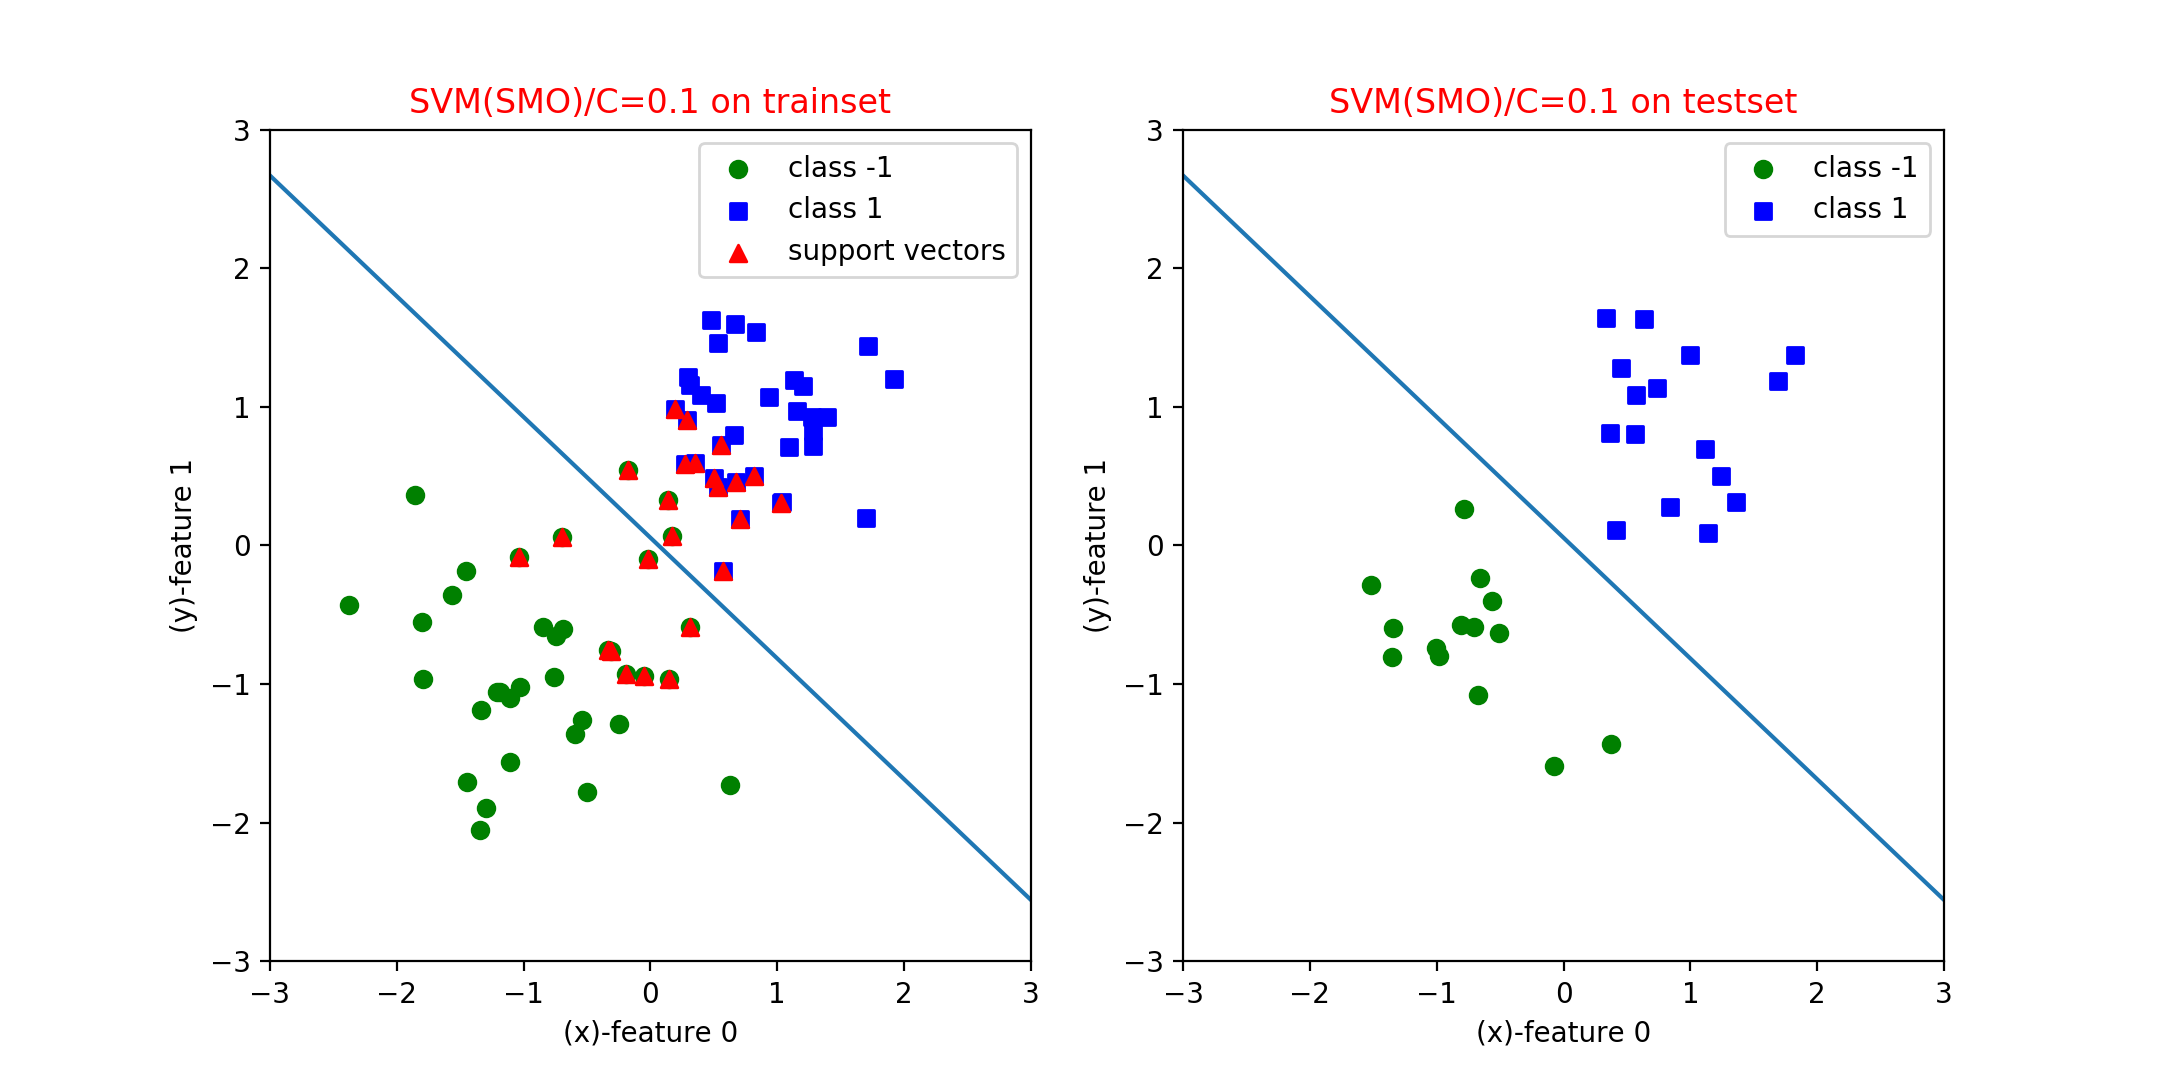

In [7]:
from sklearn import svm

def plot_svc(svc_cla, X_train, Y_train, x_test, Y_test, save_path, C=0.1):
    # train model with smo algrithm in libsvm
    svc_cla.fit(X_train, Y_train)
    print('acc on trainset: {:.3f}'.format(svc_cla.score(X_train, Y_train)))
    print('acc on testset: {:.3f}'.format(svc_cla.score(X_test, Y_test)))

    # plot param line
    W, b = np.transpose(svc_cla.coef_), svc_cla.intercept_
    print('W={}, b={}'.format(W, b))
    plt.figure(figsize=(10.8, 5.4))
    # plot support vectors
    svs = svc_cla.support_vectors_
    plot_fig(X_train, Y_train, X_test, Y_test, W, b, 'SVM(SMO)/C={:.1f}'.format(C), svs)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

cla = svm.SVC(C=0.1, kernel='linear')
plot_svc(cla, X_train, Y_train, X_test, Y_test, '../output/bg69/svm_smo_C=0.1.png')

acc on trainset: 1.000
acc on testset: 1.000
W=[[5.07938279]
 [1.64846797]], b=[-1.61300502]


<IPython.core.display.Javascript object>


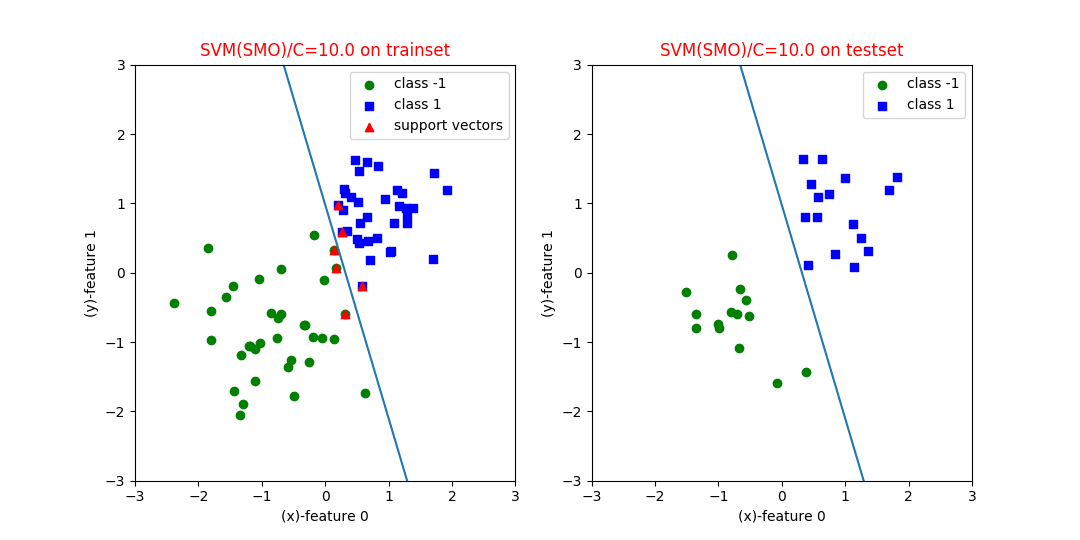

In [4]:
C = 10
cla = svm.SVC(C=C, kernel='linear')
plot_svc(cla, X_train, Y_train, X_test, Y_test, '../output/bg69/svm_smo_C=10.png', C)

从两种不同惩罚因子下的分类直线可以看出，在 C 值比较小，也就是惩罚作用比较大时，优化器会在效果和参数复杂度之间进行折中，最终选择了一种对误分类样本存在容忍，但是泛化能力更强的一种参数配置。而在 C 值较大，也就是惩罚作用较弱时，优化器试图寻找一个误分类最少的参数配置，但是最终表现出现的泛化能力却比较差。在求解SVM时，我们常常需要需要调节惩罚因子 C 来获得一组满意的模型参数。除此之外，SVC的求解器还默认加上了松弛因子，即对误分类存在一定的容忍性，也就是通常所说的软间隔。在实际使用中，基本不太会使用原理中所描述的硬间隔，而是在这个基础上加上松弛因子。更多SVC输入参数的配置情况可以参考相关手册。

## 3. 使用SGD算法优化

除了SMO算法之外，我们还可以从损失函数优化的角度来解决这个问题。现在对于损失函数优化最流行的算法是随机梯度下降(Stochastic Gradient Descent, SGD)。如果我们能够构建出SVM的损失函数，则可以通过一些深度学习通用的软件求解器来进行求解，比如tensorflow或者pytorch等等。

通过SVM原理的分析，我们可以考虑构建一种hinge损失函数，其数学表示如下：
$$
L(W, b) = \sum_{i}{\max(0, 1-y_i(WX_i+b))}
$$
该函数表示，正确分类并且置信度$y_i(WX_i+b)$大于1的样本点对损失函数贡献为0，而其他样本点则会对损失函数存在影响，从而在优化损失函数的时候有针对地调整。对于这样在开放空间上的参数解，我们通常都会增加一个正则项，以降低最终参数的复杂度。那么最终使用的损失函数可以表示如下
$$
L(W, b) = \sum_{i}{\max(0, 1-y_i(WX_i+b))} + \frac{1}{C}\|W\|^2
$$
关于某些操作在个别点存在不可导的情况，软件框架已经进行了一些修正处理，我们不需要关心这些问题。这里展示使用tensorflow2.0中的SGD求解器进行求解，在不同的惩罚因子之下，所得分类直线结果如下：

train completely, loss=0.06665483862161636
 W=[[0.7575173]
 [0.8698273]], b=[-0.05]
acc on trainset: 0.957
acc on testset: 1.000


<IPython.core.display.Javascript object>


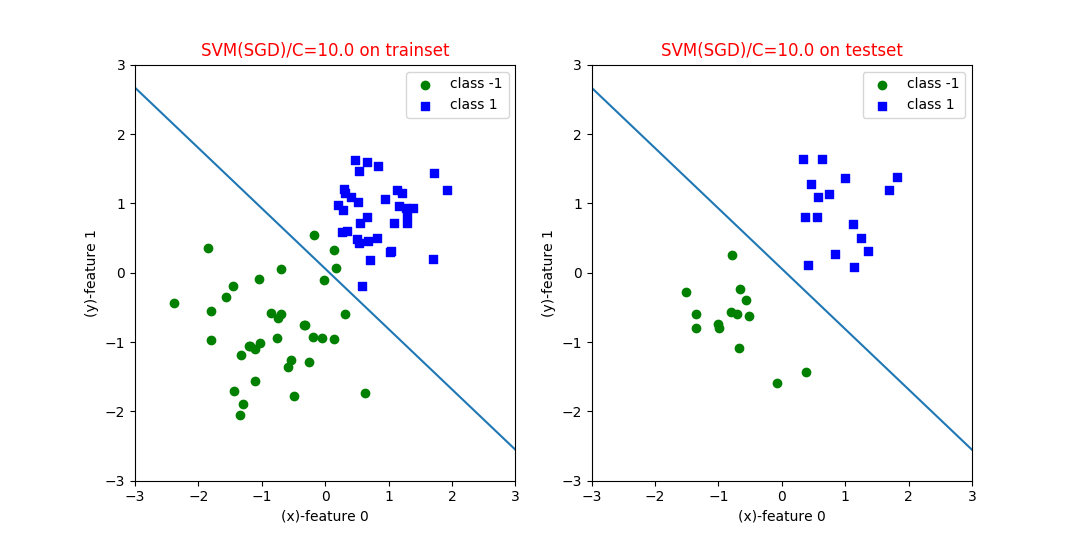

In [5]:
import tensorflow as tf

feat_dim = X_train.shape[1]
class Model:
    
    def __init__(self):
        self.W = tf.Variable(tf.zeros((feat_dim, 1)), name='features')
        self.b = tf.Variable(tf.zeros((1)), name='target')
    
    def __call__(self, x):
        return tf.sign(tf.matmul(x, self.W) + self.b)
    
    def loss(self, x, y, C=10):
        out = tf.matmul(x, self.W) + self.b
        cls = tf.reduce_mean(tf.maximum(0.0, 1.0 - out * y))
        l2 = tf.reduce_mean(tf.square(self.W))
        return cls + 1.0/C * l2
    
    def train(self, X, Y, opt, C=10):
        with tf.GradientTape() as t:
            loss_val = self.loss(X, Y, C)
        variables = [self.W, self.b]
        grad = t.gradient(loss_val, variables)
        opt.apply_gradients(zip(grad, variables))
        return loss_val
    
    def train_all(self, opt, X_train, Y_train, epoch=5, C=10):
        for epoch in range(epoch):
            for x, y in zip(X_train, Y_train):
                x = x.reshape((1, feat_dim))
                y = np.array(y)
                y = y.reshape((1,))
                loss_val = self.train(x, y, opt, C)
        print('train completely, loss={}\r\n W={}, b={}'.format(
                  loss_val.numpy(), self.W.numpy(), self.b.numpy()))
    
    def accuracy(self, X, Y):
        out = tf.squeeze(self(X))
        acc = tf.equal(out, Y)
        acc = tf.reduce_mean(tf.cast(acc, dtype=tf.float32))
        return acc
    
    def plot(self, X_train, Y_train, X_test, Y_test, save_path, C=10):
        # plot param line
        W, b = self.W.numpy(), self.b.numpy()
        plt.figure(figsize=(10.8, 5.4))
        plot_fig(X_train, Y_train, X_test, Y_test, W, b, 'SVM(SGD)/C={:.1f}'.format(C))
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

# train model
opt = tf.keras.optimizers.SGD()  
model = Model()
model.train_all(opt, X_train, Y_train, C=10)
print('acc on trainset: {:.3f}'.format(model.accuracy(X_train, Y_train)))
print('acc on testset: {:.3f}'.format(model.accuracy(X_test, Y_test)))
model.plot(X_train, Y_train, X_test, Y_test, '../output/bg69/svm_sgd_C=10.png', C=10)

train completely, loss=0.9569330215454102
 W=[[0.0912219 ]
 [0.08694614]], b=[-0.04]
acc on trainset: 0.971
acc on testset: 1.000


<IPython.core.display.Javascript object>


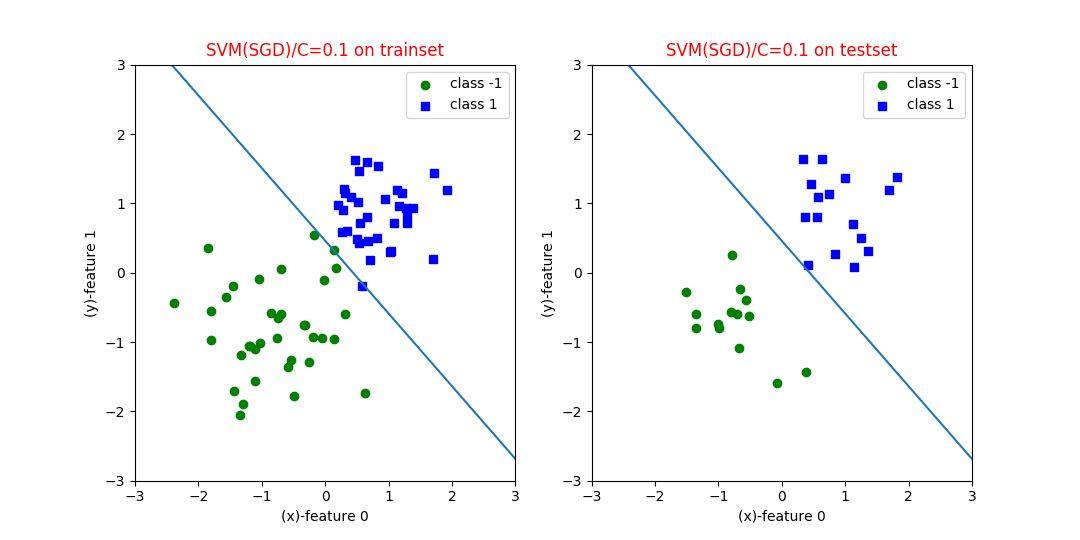

In [6]:
# train model
opt = tf.keras.optimizers.SGD()  
model = Model()
model.train_all(opt, X_train, Y_train, epoch=2, C=0.1)
print('acc on trainset: {:.3f}'.format(model.accuracy(X_train, Y_train)))
print('acc on testset: {:.3f}'.format(model.accuracy(X_test, Y_test)))
model.plot(X_train, Y_train, X_test, Y_test, '../output/bg69/svm_sgd_C=0.1.png', C=0.1)

从结果图看出，当惩罚作用越强时，优化所得参数的数值越小。在实际使用中需要调节惩罚因子，以使模型在测试集上能够得到一个不错的结果。

从两个不同的角度来看待同一个问题，就能够得到两种截然不同的解释和求解方法。使用传统的SMO算法能够非常高效的求解，使用SGD算法求解能够与现在通行的深度学习模型相融合。具体的实验代码演示，可以在本文的notebook文件中获取。

【资源分享】

github链接：https://github.com/cnbluegeek/notebook/tree/master

更多编程书籍，请发送关键字“书籍”到【青衣极客】公众号获取下载链接。

添加“cnbluegeek”微信号为好友，获得邀请加入“python交流群”，编程问题迎刃而解。